## Multilayer Perceptron

A multilayer perceptron is a type of feed forward artificial neural network with an input layer, at least one hidden layer and an output layer. It is a supervised learning model capable of learning complex non-linear relationship in the data through its interconnected layers and is trained using the backpropagation algorithm.

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from torchvision import datasets, transforms
import torch

transform = transforms.Compose([
    # Convert image (PIL/Numpy) to PyTorch Tensor
    transforms.ToTensor(),
    # Normalize the pixel values using MNIST's standard mean (0.1307) and std dev (0.3081)
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2. Download and Load DataSets

# Training Dataset (60,000 samples)
mnist_train_dataset = datasets.MNIST(
    root='./data',        # Directory where the data will be downloaded
    train=True,           # Specify training data
    download=True,        # Download if data is not already present
    transform=transform
)

# Testing Dataset (10,000 samples)
mnist_test_dataset = datasets.MNIST(
    root='./data',
    train=False,          # Specify test data
    download=True,
    transform=transform
)

X_train_tensor = torch.cat([data[0].unsqueeze(0) for data in mnist_train_dataset], dim=0)
y_train_tensor = mnist_train_dataset.targets
X_test_tensor = torch.cat([data[0].unsqueeze(0) for data in mnist_test_dataset], dim=0)
y_test_tensor = mnist_test_dataset.targets

# --------------------------------------------------------------------
# 1. Convert Feature Tensors (X) to NumPy
# We also flatten the images from (N, 1, 28, 28) to (N, 784) for ML libraries

X_train_numpy = X_train_tensor.numpy().reshape(X_train_tensor.shape[0], -1)
X_test_numpy = X_test_tensor.numpy().reshape(X_test_tensor.shape[0], -1)

# 2. Convert Label Tensors (y) to NumPy

y_train_numpy = y_train_tensor.numpy()
y_test_numpy = y_test_tensor.numpy()

print("--- NumPy Array Shapes ---")
print(f"X_train (Features): {X_train_numpy.shape}")
print(f"y_train (Labels):   {y_train_numpy.shape}")
print(f"X_test (Features):  {X_test_numpy.shape}")
print(f"y_test (Labels):    {y_test_numpy.shape}")

100.0%
100.0%
100.0%
100.0%


--- NumPy Array Shapes ---
X_train (Features): (60000, 784)
y_train (Labels):   (60000,)
X_test (Features):  (10000, 784)
y_test (Labels):    (10000,)


In [2]:
class MultiLayerPerceptron:
    """
    Simple MultiLayerPerceptron Neural Network (from scratch using NumPy).

    Uses row-major arrays throughout so that activations have shape (m, features).
    """

    def __init__(self, input_size = 786, hidden_size=128, output_size=10, lr=0.01, reg=0.0):
        rng = np.random.default_rng(45)
        self.W1 = rng.normal(0, 0.1, (input_size, hidden_size)) # (d_in, n_hidden)
        self.b1 = np.zeros((1, hidden_size)) # (1, n_hidden) numpy will broadcast this when adding
        self.W2 = rng.normal(0, 0.1, (hidden_size, output_size)) # (n_hidden, n_out)
        self.b2 = np.zeros((1, output_size)) # (1, n_out)
        self.lr = lr
        self.reg = reg

    # activation helpers
    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float) # (n, n_hidden)

    def softmax(self, Z):
        # Z: (m, n_out)
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / exp_Z.sum(axis=1, keepdims=True)

    # forward/backward
    def _forward(self, X):
        # X: (n, d_in)
        Z1 = X.dot(self.W1) + self.b1      # (n, d_in).(d_in, n_hidden) + (1, n_hidden)  -> (n, n_hidden)
        A1 = self.relu(Z1)                   # (n, n_hidden)
        Z2 = A1.dot(self.W2) + self.b2     # (n, n_hidden).(n_hidden, n_out) + (1, n_out) -> (n, n_out)
        A2 = self.softmax(Z2)                # (n, n_out)
        return Z1, A1, Z2, A2

    def _backward(self, X, y, Z1, A1, Z2, A2):
        m = X.shape[0]
        y_one_hot = self.one_hot_encode(y, A2.shape[1])  # (n, n_out)


        # Output error signal
        dZ2 = A2 - y_one_hot                             # (n, n_out)
        dW2 = (1.0 / m) * (A1.T.dot(dZ2))                # (n_hidden, n).(n, n_out) -> (n_hidden, n_out)
        db2 = (1.0 / m) * np.sum(dZ2, axis=0, keepdims=True)  # (1, n_out)

        # Hidden layer error signal
        dA1 = dZ2.dot(self.W2.T)                           # (n , n_out). (n_out, n_hidden) -> (n, n_hidden)
        dZ1 = dA1 * self.relu_derivative(Z1)             # (n, n_hidden)
        dW1 = (1.0 / m) * (X.T.dot(dZ1))                 # (n_in, n) . (n, n_hidden) -> (n_in, n_hidden)
        db1 = (1.0 / m) * np.sum(dZ1, axis=0, keepdims=True)  # (1, n_hidden)

        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return grads

    def update_parameters(self, grads):
        self.W1 -= self.lr * grads["dW1"]
        self.b1 -= self.lr * grads["db1"]
        self.W2 -= self.lr * grads["dW2"]
        self.b2 -= self.lr * grads["db2"]

    def one_hot_encode(self, y, num_classes):
        # y: (n,) -> return (n, num_classes)
        y_int = y.astype(int).ravel()
        m = y_int.size
        one_hot = np.zeros((m, num_classes))
        one_hot[np.arange(m), y_int] = 1
        return one_hot # (n, num_classes)

    def compute_loss(self, y, A2):
        # y: (m,), A2: (m, n_out)

        # Loss function is cross entropy and is given as follows
        """

            L = - (1/N) SUMMATION_from_i=1_to_N y(i)_one_hot * log( A2(i) )

        """

        m = y.shape[0]
        eps = 1e-12
        num_classes = A2.shape[1]

        Y = self.one_hot_encode(y, num_classes)
        log_probs = np.log(A2 + eps)
        data_loss = -np.sum(Y * log_probs) / m
        reg_loss = 0.5 * self.reg * (np.sum(self.W1 * self.W1) + np.sum(self.W2 * self.W2))
        return data_loss + reg_loss


    """
        Batch:
        ---------------------------------------------------------------------------------------------
        A batch is a subset of training data that is required to make one forward + one backward pass.

        Example:
        N = Total Training Samples = 10000
        B = Batch Size = 100
        Number of Batches = Total Training Samples / Batch Size = 10000/ 100 = 100 Batches
        1 Batch contains exactly 100 samples.
        ---------------------------------------------------------------------------------------------

        Iteration:
        ---------------------------------------------------------------------------------------------
        An iteration is one update of the model's parameters.
        1 iteration = 1 forward pass + 1 backward pass = 1 parameter update.

        number of iterations per epoch = N/B
        N = Total Training Samples = 10000
        B = Batch Size = 100
        number of iterations per epoch = 10000/100 = 100 iterations per epoch.
        ----------------------------------------------------------------------------------------------

        Epoch:
        ---------------------------------------------------------------------------------------------
        Epoch means one complete pass through the entire training dataset.
        In one epoch, all training samples are used once to update the model's parameters.

        1 epoch  = all batches processed once

        Example:
        If you train for 20 epochs then the model will see the entire training dataset 20 times.
        ---------------------------------------------------------------------------------------------
    """


    def fit(self, X, y, epochs=10, batch_size=64):
        # X (n, d_in)
        m = X.shape[0] # n
        loss_history = []
        for epoch in range(epochs):
            for i in range(0, m, batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                Z1, A1, Z2, A2 = self._forward(X_batch)
                grads = self._backward(X_batch, y_batch, Z1, A1, Z2, A2)
                self.update_parameters(grads)

            # evaluate on full dataset at end of epoch
            _, _, _, A2_all = self._forward(X)
            epoch_loss = self.compute_loss(y, A2_all)
            loss_history.append(epoch_loss)

            preds = np.argmax(A2_all, axis=1)
            acc = np.mean(preds == y)
            print(f"Epoch {epoch:3d}/{epochs}  loss={epoch_loss:.4f}  acc={acc:.4f}")

        return loss_history

    def predict(self, X):
        _, _, _, A2 = self._forward(X)
        return np.argmax(A2, axis=1)

    def score(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)


In [3]:
def show_image(X, y, idx):
    image = X[idx,:].reshape(28, 28)
    label = y[idx]
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
    return label

In [4]:
def show_image_matches(model, X, y, index):
    pred = model.predict(X[index,:])
    label = show_image(X, y, index)
    if pred == label:
        print(f"Model Prediction: {pred} (Correct)")
    else:
        print(f"Model Prediction: {pred} (Incorrect)")

In [5]:
ann = MultiLayerPerceptron(input_size=784, hidden_size=128, output_size=10)

In [6]:
loss_hist = ann.fit(X_train_numpy, y_train_numpy, epochs=50, batch_size=64)

Epoch   0/50  loss=0.3402  acc=0.8976
Epoch   1/50  loss=0.2664  acc=0.9214
Epoch   2/50  loss=0.2271  acc=0.9337
Epoch   3/50  loss=0.2005  acc=0.9416
Epoch   4/50  loss=0.1807  acc=0.9480
Epoch   5/50  loss=0.1652  acc=0.9523
Epoch   6/50  loss=0.1526  acc=0.9559
Epoch   7/50  loss=0.1421  acc=0.9590
Epoch   8/50  loss=0.1331  acc=0.9615
Epoch   9/50  loss=0.1253  acc=0.9638
Epoch  10/50  loss=0.1184  acc=0.9658
Epoch  11/50  loss=0.1123  acc=0.9676
Epoch  12/50  loss=0.1069  acc=0.9693
Epoch  13/50  loss=0.1019  acc=0.9709
Epoch  14/50  loss=0.0974  acc=0.9722
Epoch  15/50  loss=0.0933  acc=0.9735
Epoch  16/50  loss=0.0896  acc=0.9743
Epoch  17/50  loss=0.0861  acc=0.9755
Epoch  18/50  loss=0.0828  acc=0.9768
Epoch  19/50  loss=0.0798  acc=0.9778
Epoch  20/50  loss=0.0770  acc=0.9786
Epoch  21/50  loss=0.0743  acc=0.9794
Epoch  22/50  loss=0.0718  acc=0.9801
Epoch  23/50  loss=0.0694  acc=0.9807
Epoch  24/50  loss=0.0671  acc=0.9814
Epoch  25/50  loss=0.0650  acc=0.9822
Epoch  26/50

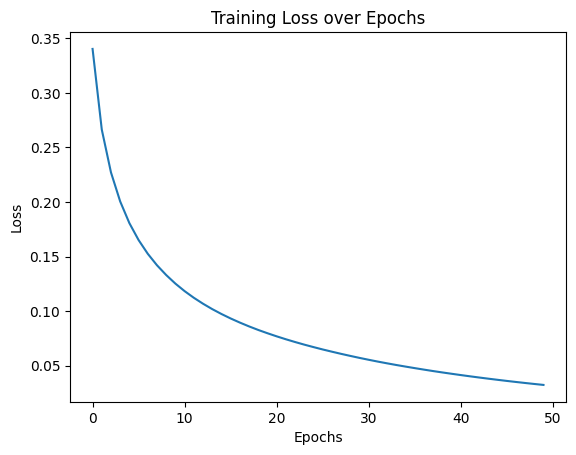

In [7]:
# PLot loss history
plt.plot([epoch for epoch in range(50)],loss_hist)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

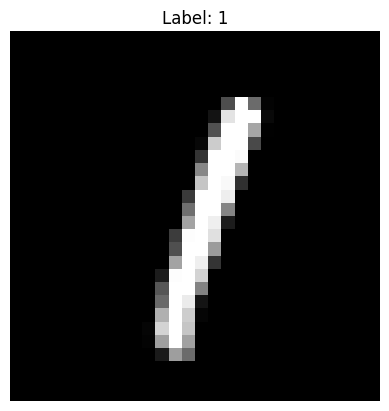

Model Prediction: [1] (Correct)




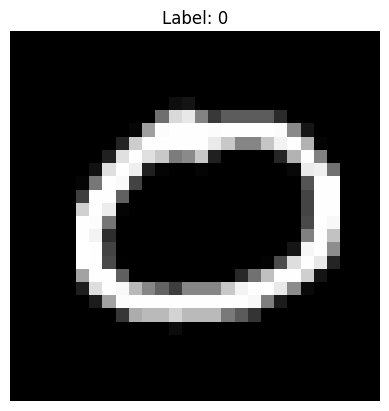

Model Prediction: [0] (Correct)




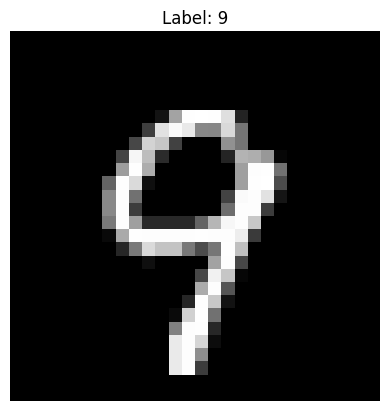

Model Prediction: [9] (Correct)




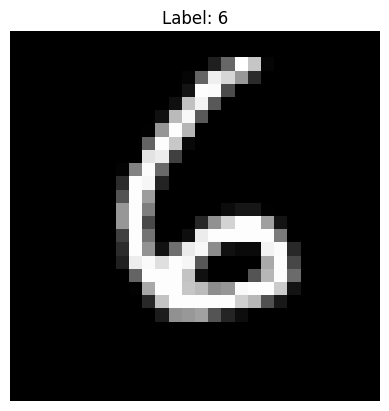

Model Prediction: [6] (Correct)




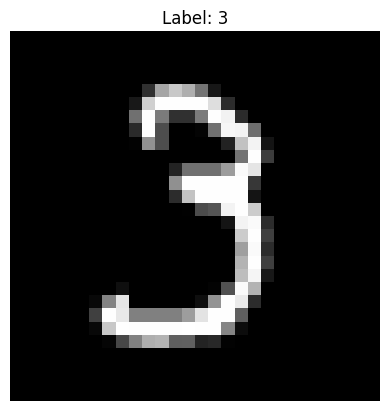

Model Prediction: [3] (Correct)




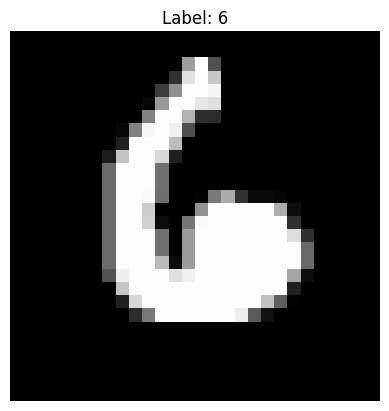

Model Prediction: [6] (Correct)




In [8]:
index = [5,69,758,600,4586 ,9568]
for idx in index:
    show_image_matches(ann, X_test_numpy, y_test_numpy, idx)
    ann.predict(X_test_numpy[idx,:])
    print('\n')